### <font color="blue">✨ ***Multimodal RAG: Use Multimodal LLM to Summarize Images and Embed Text Summaries 📸➡️📝***</font>


### <font color="blue"> ***INTRODUCTION 🥇*** </font>
If we have already implemented a Retrieval-Augmented Generation (RAG) pipeline that handles only textual data and now want to incorporate information from images, I propose transforming all data into a single modality: text. This approach allows us to retain our current architecture and continue embedding the data using a text-embedding model.

To achieve this, we can use an open-source multimodal LLM, such as Llama3.2-vision, to extract summaries from images.


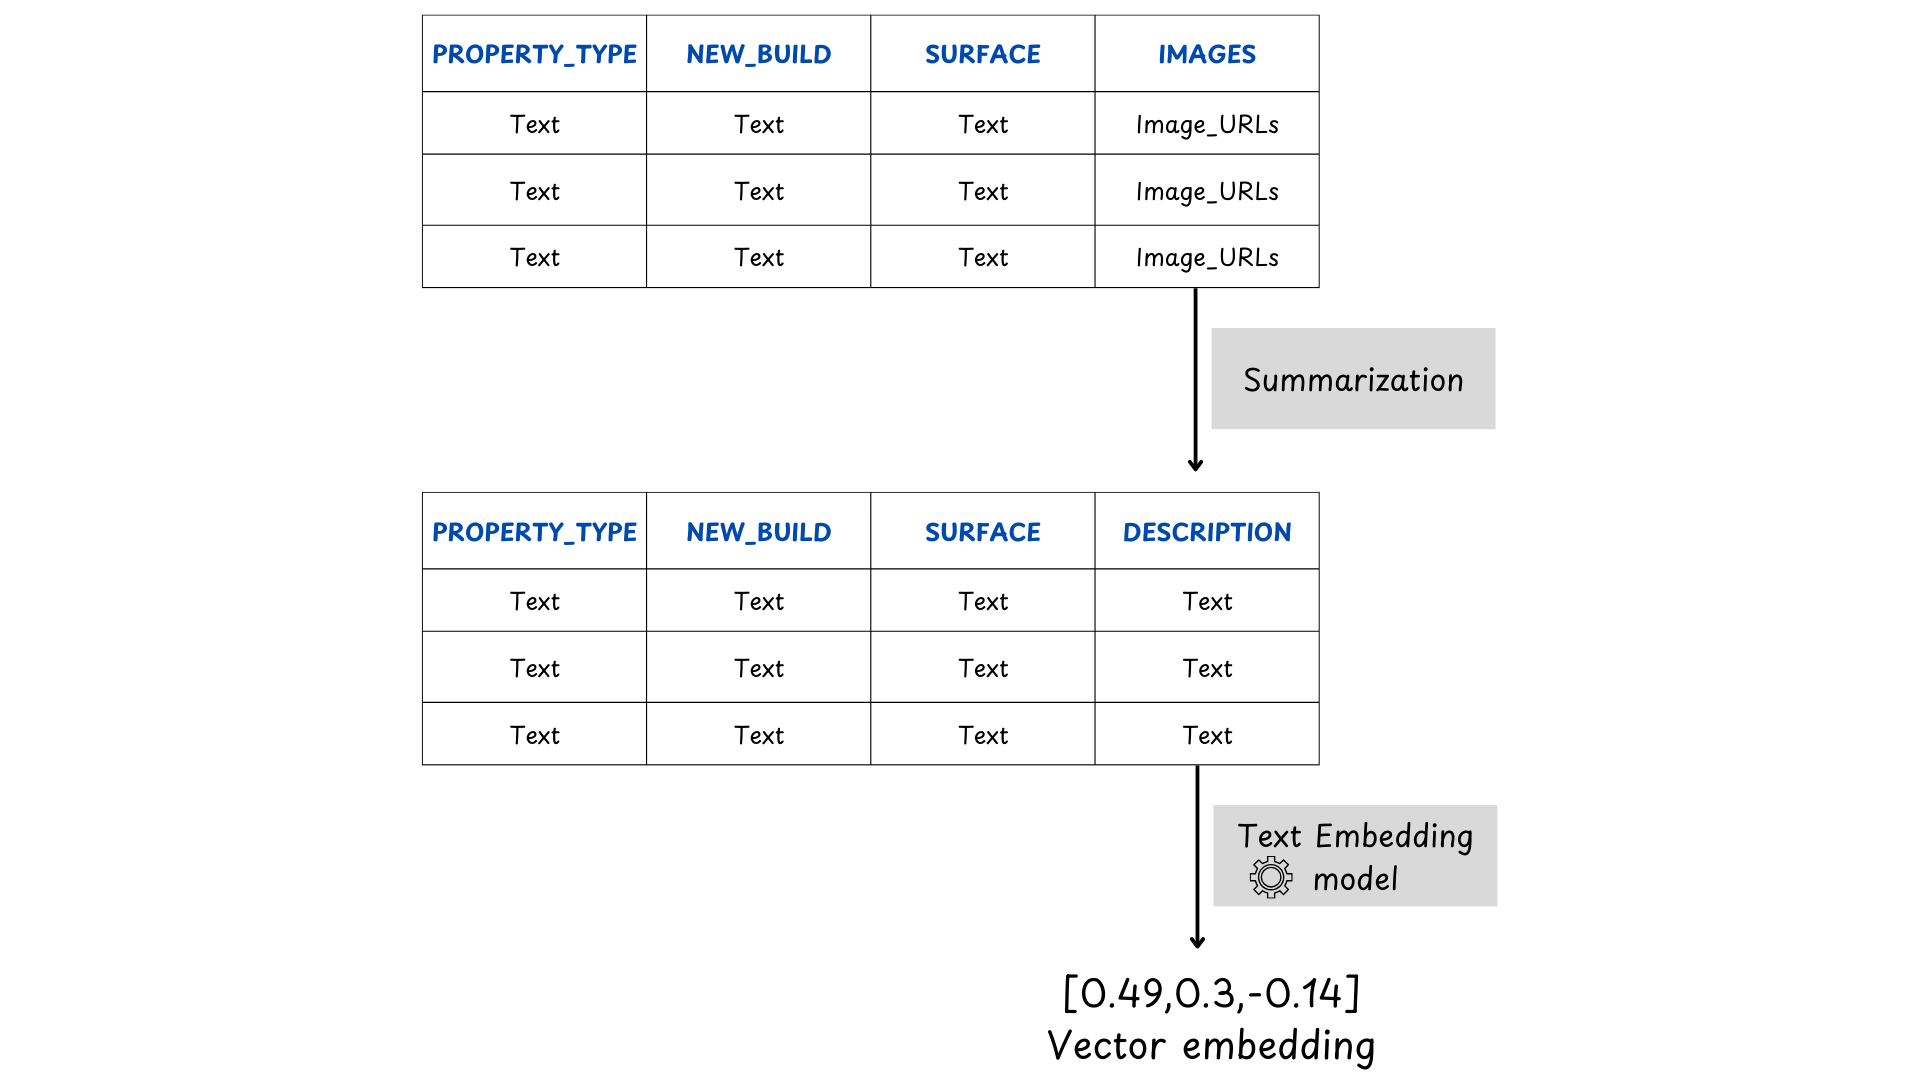

#### <font color="#D6B4FC"> ***Import librairies ✍*** </font> :
**Groq**: access Llama3.2 through the GroqCloud Models API endpoint.

**LangChain**: implement our custom RAG pipeline  

In [ ]:
!pip -q install groq langchain langchain_community langchain_huggingface langchain_groq chromadb lark

In [2]:
!pip show langchain

Name: langchain
Version: 0.3.8
Summary: Building applications with LLMs through composability
Home-page: https://github.com/langchain-ai/langchain
Author: 
Author-email: 
License: MIT
Location: /usr/local/lib/python3.10/dist-packages
Requires: aiohttp, async-timeout, langchain-core, langchain-text-splitters, langsmith, numpy, pydantic, PyYAML, requests, SQLAlchemy, tenacity
Required-by: langchain-community


In [2]:
import pandas as pd
from groq import Groq
import os
import requests
import ast

In [3]:
os.environ["GROQ_API_KEY"] = "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"

In this notebook, I demonstrate this concept using a sample dataset: a csv of property ads. The dataset includes a column  <font color="#D6B4FC">"IMAGES"</font> of image URLs. The process involves summarizing the images and adding a new column, <font color="#D6B4FC">"DESCRIPTION" </font>
, text summaries.

In [22]:
# Load dataset CSV file to pandas DataFrame
data=pd.read_csv("/content/ADS-Dataset.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PROPERTY_TYPE   50 non-null     object 
 1   NEW_BUILD       50 non-null     bool   
 2   IMAGES          50 non-null     object 
 3   SURFACE         50 non-null     float64
 4   ROOM_COUNT      50 non-null     float64
 5   PARKING         50 non-null     bool   
 6   MARKETING_TYPE  50 non-null     object 
 7   PRICE           50 non-null     float64
 8   CITY_ID         50 non-null     int64  
 9   CITY            50 non-null     object 
dtypes: bool(2), float64(3), int64(1), object(4)
memory usage: 3.3+ KB


In [26]:
data.head(2)

,PROPERTY_TYPE,NEW_BUILD,IMAGES,SURFACE,ROOM_COUNT,PARKING,MARKETING_TYPE,PRICE,CITY_ID,CITY
0,APARTMENT,False,"[""https://cf-medias.avendrealouer.fr/image/_87...",72.0,3.0,True,RENT,1979.0,54178039,Levallois-Perret
1,APARTMENT,False,"[""http://photos.ubiflow.net/440414/165474561/p...",48.0,2.0,False,SALE,429000.0,54178039,Levallois-Perret


### <font color="#D6B4FC">Data Preparation 📖</font>

In [7]:
# Returns True if valid image URL, otherwise False
def is_valid_image_url(img_url):
  try:
    response=requests.head(img_url,timeout=5)
    return response.status_code==200
  except Exception:
    return False

In [32]:
# Remove invalid image URLs and drop rows from the DataFrame in case no image URLs
for i, row in data.iterrows():
    imgs = ast.literal_eval(row["IMAGES"])
    valid_imgs = [img for img in imgs if is_valid_image_url(img)] # filter image URLs
    data.at[i, "IMAGES"] = str(valid_imgs) # update "IMAGES" column with valid URLs
# drop rows with no valid image URLs as my objective is to extract a detailed description from images
data = data[data["IMAGES"] != "[]"].reset_index(drop=True)

In [35]:
# Returns a response from the LLM Llama-3.2-11b-vision (Groq API) (image summary)
def image_summarize(img_url,prompt):
    ''' Image summary '''
    client = Groq(api_key=os.environ.get("GROQ_API_KEY"))
    response = client.chat.completions.create(
    model="llama-3.2-11b-vision-preview",
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": prompt
                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": img_url
                    }
                }
            ]
        }
    ],
    temperature=1,
    max_tokens=512,
    top_p=1,
    stream=False,
    stop=None,
    )
    content = response.choices[0].message.content
    return content

In [36]:
# Example to summarize an image
img_url="https://v.seloger.com/s/width/965/visuels/0/9/3/7/0937mk01pff7dkq2n4dhqcwehdoaa4okzpmzc1zwg.jpg"
prompt = "Describe the image in detail."
summary=image_summarize(img_url,prompt)
print(summary)

The image is a photograph of a wooden deck and staircase with palm trees and bushes on either side. 

The deck is made up of light-colored wood, arranged in a pattern of rectangular sections, each one with slightly overhanging edges, some adorned with bushes in square planters and three palm trees. A set of stairs in the background of the image opens up to different levels of the deck.

In the center of the image, there is a watermark that reads "Proprietes Sotheby's Paris 106 Rue du Faubourg Saint-Honore 75008 ARPTB" in translucent white text.

In the background, there are tall green trees and blue sky above the deck.


In [37]:
prompt = "Describe the image in detail."
df=data
df["DESCRIPTION"]=""
for ind in df.index:
  imgs=df["IMAGES"][ind]
  img_urls=ast.literal_eval(imgs)
  img_summaries=[]
  for img_url in img_urls:
    summarization = image_summarize(img_url,prompt)
    summary = {'path': img_url,
               'media_type':'image',
               'description' : summarization}
    img_summaries.append(summary)
    df.loc[ind,"DESCRIPTION"]= str(img_summaries) # Add text summary for each image_url in 'DESCRIPTION' column
df=df.drop("IMAGES",axis=1)

In [39]:
print(df["DESCRIPTION"][2])

[{'path': 'https://v.seloger.com/s/width/966/visuels/0/1/i/d/01idozdpkiqhx4m3geazwntv1tlizbmrgbsowuxqr.jpg', 'media_type': 'image', 'description': 'This image depicts a serene modern outdoor patio, showcasing wooden decking, sleek contemporary architecture, and tasteful indoor decorating. The wooden deck serves as the primary focus of the image. In the foreground, two vibrant yellow chairs provide a pop of color, surrounded by sturdy gray pots holding lush green plants. Along the left wall, thick monochrome plant pots are strategically placed, adding a sense of calm and connection to nature.\n\nTwo small square wooden tables, crafted from medium-grained wooden planks, are arranged in the bottom left corner of the image. The tables are adorned with small green plants situated in pots, and light wooden dividers are visible at their base.\n\nIn the background on the left side of the image, a gray, monochromatic textured wall provides a striking contrast, featuring a portion comprising a s

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PROPERTY_TYPE   26 non-null     object 
 1   NEW_BUILD       26 non-null     bool   
 2   SURFACE         26 non-null     float64
 3   ROOM_COUNT      26 non-null     float64
 4   PARKING         26 non-null     bool   
 5   MARKETING_TYPE  26 non-null     object 
 6   PRICE           26 non-null     float64
 7   CITY_ID         26 non-null     int64  
 8   CITY            26 non-null     object 
 9   DESCRIPTION     26 non-null     object 
dtypes: bool(2), float64(3), int64(1), object(4)
memory usage: 1.8+ KB


In [25]:
df.to_csv("ADS-dataset-text.csv",index=False)

#### <font color="#D6B4FC"> ***Multimodal RAG ( Embedd text and image summaries) ✍*** </font>:
*This idea is based on retaining the traditional RAG pipeline working with a Text embedding model and approach the multimoadal RAG at the same time: transform all different data types into a single modality:text,*

*In our use case, the workflow follows these steps:*

1. summarize the image to a text description using the open-source model Llama3.2-vision model via GROQ CLOUD.
2. Add a new column, "DESCRIPTION," for each row to include the image summaries in the following format:
{'path': img_url, 'media_type': 'image', 'description': summarization}.
3. Load data from a CSV file, where each row becomes a document. The "DESCRIPTION" column serves as the page_content, and the other columns are included as metadata to perform SelfQueryRetriever. <font color="blue">This approach is specifically chosen to evaluate the effectiveness of extracting information and specific details from images.</font>
4. Store data in a Chroma vector store.

In [4]:
from langchain_community.document_loaders.csv_loader import CSVLoader

file_path = "/content/ADS-dataset-text.csv"
loader = CSVLoader(file_path=file_path,metadata_columns=["PROPERTY_TYPE","MARKETING_TYPE","NEW_BUILD","ROOM_COUNT","SURFACE","PARKING","PRICE","CITY_ID","CITY"])
docs = loader.load()

In [ ]:
from langchain.vectorstores import Chroma
# Load Embedding model:
from langchain_huggingface import HuggingFaceEmbeddings
model_name = "sentence-transformers/all-mpnet-base-v2"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': False}
embeddings = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)
vectorstore = Chroma.from_documents(docs, embeddings)

In [6]:
from langchain.retrievers.multi_query import MultiQueryRetriever
from langchain_groq import ChatGroq
llm= ChatGroq(model="llama3-8b-8192")

retriever_from_llm = MultiQueryRetriever.from_llm(
    retriever=vectorstore.as_retriever(),
    llm=llm,
)

#### <font color="#D6B4FC"> ***Results:✍*** </font>: perform highly specific and detailed searches based on the image descriptions

In [13]:
relevant_data = retriever_from_llm.invoke("I search for a modern spacious fully furnished office with glass doors")
print("Top-K documents",len(relevant_data))
print(relevant_data[0].page_content)

Top-K documents 7
DESCRIPTION: [{'path': 'https://v.seloger.com/s/cdn/x/visuels/0/z/d/0/0zd0drlinjodkaiqh47jqzl8l7ggbnbmmqtlijk3k.jpg', 'media_type': 'image', 'description': 'The image depicts a five-story office building in an urban setting. \n\nThe building is made of light-colored stone and has curved lines, emphasizing its three-dimensional appearance. It features a large window on the top level, a balcony, a shiny stained glass front door, and a walkway entrance with additional glass doors on the bottom floor. Above the entrance, rectangular lights indicate a common commercial lighting design. \n\nOn the left side of the image, a large tree with small leaves is visible, approximately three stories tall, giving some context to the building\'s location on a typical urban street. \n\nOn the right side of the image, the top of an individual wearing sunglasses is visible and, hanging on the building, is a cylindrical street lamp with light bulbs. \n\nIn the background, there is a grey 

#### <font color="#D6B4FC"> ***Next steps:✍*** </font>: filter relevant data based on metadata (Not finished yet)

In [8]:
from langchain.retrievers.self_query.base import SelfQueryRetriever
from langchain.chains.query_constructor.base import AttributeInfo

# metadata_field_info
metadata_field_info = [
    AttributeInfo(
        name="PROPERTY_TYPE",
        description="The type of the property, such as apartment, house, etc.",
        type="string or list[string]",
    ),
    AttributeInfo(
        name="NEW_BUILD",
        description="Indicates whether the property is newly built.",
        type="boolean",
    ),
    AttributeInfo(
        name="SURFACE",
        description="The surface area of the property.",
        type="float",
    ),
    AttributeInfo(
        name="ROOM_COUNT",
        description="The number of rooms in the property.",
        type="float",
    ),
    AttributeInfo(
        name="PARKING",
        description="Indicates whether the property has parking available.",
        type="boolean",
    ),
    AttributeInfo(
        name="MARKETING_TYPE",
        description="The type of marketing strategy used, such as sale, rental, etc.",
        type="string or list[string]",
    ),
    AttributeInfo(
        name="PRICE",
        description="The price of the property in the local currency.",
        type="float",
    ),
    AttributeInfo(
        name="CITY_ID",
        description="The unique identifier for the city where the property is located.",
        type="integer",
    ),
    AttributeInfo(
        name="CITY",
        description="The name of the city where the property is located.",
        type="string",
    ),
]

# Description for document content
document_content_description = "A detailed description of the property."


In [17]:
retriever = SelfQueryRetriever.from_llm(
    llm,
    vectorstore,
    document_content_description,
    metadata_field_info,
    verbose=True
)